# Lesson 10 - Sentiment Analysis
Author: Ajai Shukla
This assignment requires that you build a sentiment analysis classifier for a series of tweets.
The data consists of a file "twitter_data.csv". The file contains 16,000 tweets with their respective score. The attributes are the sentences, and the score is either 4 (for positive) or 0 (for negative).

Assignment Instructions
1. Complete all questions below.
2. Comment on the applicability of the model on future tweets.  

In [1]:
!conda install -c conda-forge arrow -y

Solving environment: done

# All requested packages already installed.



In [2]:
!conda install -c conda-forge editdistance -y

Solving environment: done

# All requested packages already installed.



In [3]:
!pip search nltk

rake-nltk (1.0.4)                - Python implementation of the Rapid
                                   Automatic Keyword Extraction algorithm
                                   using NLTK
nltk (3.4.3)                     - Natural Language Toolkit
  INSTALLED: 3.4
  LATEST:    3.4.3
ko-nltk (0.1)                    - 
nltkrest (0.12)                  - NLTK as a REST service
nltk_tgrep (1.0.6)               - tgrep2 Searching for NLTK Trees
nltkjsonnlp (0.0.5)              - The Python NLTK JSON-NLP package
lektor-natural-language (0.3.1)  - Adds NLTK based template filters.
cnpt-leos (0.1.1)                - Custom NLTK part of speech tagger
bluestocking (0.1.2)             - An information extraction toolkit built on
                                   top of NLTK.
wordgrapher (0.3.1)              - Word Graph utility built with NLTK and
                                   TextBlob
text_operations (0)              - A set of functions that piggyback off nltk
                         

In [ ]:
!conda list nltk

# packages in environment at /anaconda3:
#
# Name                    Version                   Build  Channel
nltk                      3.4                      py37_1  


In [ ]:
!conda install nltk

Solving environment: done

## Package Plan ##

  environment location: /anaconda3

  added / updated specs:
    - nltk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.3.9           |           py37_0         155 KB
    conda-4.6.14               |           py37_0         2.1 MB
    openssl-1.1.1b             |       h1de35cc_1         3.4 MB
    ------------------------------------------------------------
                                           Total:         5.7 MB

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi                                       conda-forge --> pkgs/main
  conda                                         conda-forge --> pkgs/main
  openssl                                       conda-forge --> pkgs/main


Proceed ([y]/n)? 

In [1]:
#Imports
import csv
import editdistance
import string
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Specialty libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from scipy.sparse import coo_matrix
from collections import Counter
import argparse
import pprint

In [2]:
# Hamming Distance
def hamming_dist(text1, text2):
    # For strings of equal length:
    assert len(text1) == len(text2)
    return sum(char1 != char2 for char1, char2 in zip(text1, text2))

print('Hamming(101101, 100011) = {}'.format(hamming_dist('101101', '100011')))
print('Hamming(bear, beer) = {}'.format(hamming_dist('bear', 'beer')))

Hamming(101101, 100011) = 3
Hamming(bear, beer) = 1


In [3]:
# Levenshtein Distance (edit distance)
print('Lev_Dist(bear, beer) = {}'.format(editdistance.eval('bear', 'beer')))

print('Lev_Dist(banana, ban) = {}'.format(editdistance.eval('banana', 'ban')))

Lev_Dist(bear, beer) = 1
Lev_Dist(banana, ban) = 3


In [4]:
# Jaccard Index Distance
def jaccard_ix_dist(text1, text2):
    set1 = set(list(text1))
    set2 = set(list(text2))
    return 1 - (len(set1.intersection(set2)) / float(len(set1.union(set2))))


print('Jaccard(bear, beer) = {}'.format(jaccard_ix_dist('beer', 'bear')))

# The following may be an issue...
print('Jaccard(banana, ban) = {}'.format(jaccard_ix_dist('banana', 'ban')))

Jaccard(bear, beer) = 0.25
Jaccard(banana, ban) = 0.0


In [5]:
# Weighted Jaccard Index
def weighted_jaccard_dist(text1, text2):
    set1 = set(list(text1))
    set2 = set(list(text2))
    union = set1.union(set2)
    
    min_sum = 0
    max_sum = 0
    for char in union:
        min_sum += min(text1.count(char), text2.count(char))
        max_sum += max(text1.count(char), text2.count(char))
    
    return 1 - (min_sum / max_sum)

print('Weighted Jaccard(bear, beer) = {}'.format(weighted_jaccard_dist('beer', 'bear')))

print('Weighted Jaccard(banana, ban) = {}'.format(weighted_jaccard_dist('banana', 'ban')))

Weighted Jaccard(bear, beer) = 0.4
Weighted Jaccard(banana, ban) = 0.5


In [6]:
# Text cleaning example
horrible_tweet_text = 'I <3 statistics $\ \ $, it’s my \u1072  $\ \ $    fAvoRitE!! 11!!!'
print('Unfiltered text: \n{}\n'.format(horrible_tweet_text))

Unfiltered text: 
I <3 statistics $\ \ $, it’s my ၲ  $\ \ $    fAvoRitE!! 11!!!



In [7]:
# Remove non-ascii unicode
clean1 = ''.join([x for x in horrible_tweet_text if ord(x) < 128])
print('Removed non-ascii unicode: \n{}\n'.format(clean1))

Removed non-ascii unicode: 
I <3 statistics $\ \ $, its my   $\ \ $    fAvoRitE!! 11!!!



In [8]:
# Remove uppercase
clean2 = clean1.lower()
print('Lowercased: \n{}\n'.format(clean2))

Lowercased: 
i <3 statistics $\ \ $, its my   $\ \ $    favorite!! 11!!!



In [9]:
# Remove punctuation
exclude = set(string.punctuation)
clean3 = ''.join(char for char in clean2 if char not in exclude)
print('No Punctuation: \n{}\n'.format(clean3))

No Punctuation: 
i 3 statistics    its my         favorite 11



In [10]:
# Remove numbers
clean4 = re.sub("\d+", "", clean3)
print('Removed numbers: \n{}\n'.format(clean4))

Removed numbers: 
i  statistics    its my         favorite 



In [11]:
# Strip extra whitespace
clean5 = ' '.join(clean4.split())
print('Stripped extra whitespace: \n{}\n'.format(clean5))

Stripped extra whitespace: 
i statistics its my favorite



In [12]:
# Remove stopwords
word_list = clean5.split(' ')
clean_word_list = [word for word in word_list if word not in stopwords.words('english')]
clean6 = ' '.join(clean_word_list)
print('Removed stopwords like: {} ...'.format(stopwords.words('english')[0:5]))
print(clean6)

Removed stopwords like: ['i', 'me', 'my', 'myself', 'we'] ...
statistics favorite


In [15]:
# Stem Words
from nltk.stem import WordNetLemmatizer
lmtzr = WordNetLemmatizer()
stemmed_words = [lmtzr.lemmatize(word) for word in clean_word_list]
clean7 = ' '.join(stemmed_words)
print('\nStemmed Words: \n{}\n'.format(clean7))


Stemmed Words: 
statistic favorite



In [16]:
# Create a function to do this
def preprocess(text, list_of_steps):
    
    for step in list_of_steps:
        if step == 'remove_non_ascii':
            text = ''.join([x for x in text if ord(x) < 128])
        elif step == 'lowercase':
            text = text.lower()
        elif step == 'remove_punctuation':
            punct_exclude = set(string.punctuation)
            text = ''.join(char for char in text if char not in punct_exclude)
        elif step == 'remove_numbers':
            text = re.sub("\d+", "", text)
        elif step == 'strip_whitespace':
            text = ' '.join(text.split())
        elif step == 'remove_stopwords':
            stops = stopwords.words('english')
            word_list = text.split(' ')
            text_words = [word for word in word_list if word not in stops]
            text = ' '.join(text_words)
        elif step == 'stem_words':
            lmtzr = WordNetLemmatizer()
            word_list = text.split(' ')
            stemmed_words = [lmtzr.lemmatize(word) for word in word_list]
            text = ' '.join(stemmed_words)
    return text

step_list = ['remove_non_ascii', 'lowercase', 'remove_punctuation', 'remove_numbers',
            'strip_whitespace', 'remove_stopwords', 'stem_words']
print(preprocess(horrible_tweet_text, step_list))

statistic favorite


In [18]:
import numpy as np
import pandas as pd

In [20]:
#Read files
url = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/twitter_data.csv"
df = pd.read_csv(url, sep=",")
df.columns = ["sentiment_label","tweet_text"]
    
print(df.head())


   sentiment_label                                         tweet_text
0                4  @elephantbird Hey dear, Happy Friday to You  A...
1                4  Ughhh layin downnnn    Waiting for zeina to co...
2                0  @greeniebach I reckon he'll play, even if he's...
3                0              @vaLewee I know!  Saw it on the news!
4                0  very sad that http://www.fabchannel.com/ has c...


# Q1: Generate word cloud for positive sentiment.

In [21]:
# But sentiment is either '4' or '0'. We'll change that to '1' or '0' to indicate positive or negative sentiment.
df.sentiment_label=df.sentiment_label.replace(4,1)

# Check the Data frame again
print(df.head())

print('\n\n{}'.format(df['sentiment_label'].describe()))

print('\n\n Count of positives: {}'.format(np.sum(df['sentiment_label'])))

   sentiment_label                                         tweet_text
0                1  @elephantbird Hey dear, Happy Friday to You  A...
1                1  Ughhh layin downnnn    Waiting for zeina to co...
2                0  @greeniebach I reckon he'll play, even if he's...
3                0              @vaLewee I know!  Saw it on the news!
4                0  very sad that http://www.fabchannel.com/ has c...


count    160000.000000
mean          0.500000
std           0.500002
min           0.000000
25%           0.000000
50%           0.500000
75%           1.000000
max           1.000000
Name: sentiment_label, dtype: float64


 Count of positives: 80000


# Q2: Generate word cloud for negative sentiment.

In [22]:
# But sentiment is either '4' or '0'. We'll change that to '1' or '0' to indicate positive or negative sentiment.
df.sentiment_label=df.sentiment_label.replace(4,1)
print(df.head())

print('\n\n{}'.format(df['sentiment_label'].describe()))

print('\n\n Count of negatives: {}'.format(np.sum(df['sentiment_label'])))

   sentiment_label                                         tweet_text
0                1  @elephantbird Hey dear, Happy Friday to You  A...
1                1  Ughhh layin downnnn    Waiting for zeina to co...
2                0  @greeniebach I reckon he'll play, even if he's...
3                0              @vaLewee I know!  Saw it on the news!
4                0  very sad that http://www.fabchannel.com/ has c...


count    160000.000000
mean          0.500000
std           0.500002
min           0.000000
25%           0.000000
50%           0.500000
75%           1.000000
max           1.000000
Name: sentiment_label, dtype: float64


 Count of negatives: 80000


# Q3: Split data into 70% for training and 30% for testing.

In [27]:
# Convert a copy of the tweets as list for use later
tweet_data = df.values.tolist()

In [29]:
# Clean tweets
steps = ['lowercase', 'remove_punctuation', 'remove_numbers', 'strip_whitespace']

df['clean_tweet'] = df['tweet_text'].map(lambda s: preprocess(s, steps))

In [30]:
df.head()

,sentiment_label,tweet_text,clean_tweet
0,1,"@elephantbird Hey dear, Happy Friday to You A...",elephantbird hey dear happy friday to you alre...
1,1,Ughhh layin downnnn Waiting for zeina to co...,ughhh layin downnnn waiting for zeina to cook ...
2,0,"@greeniebach I reckon he'll play, even if he's...",greeniebach i reckon hell play even if hes not...
3,0,@vaLewee I know! Saw it on the news!,valewee i know saw it on the news
4,0,very sad that http://www.fabchannel.com/ has c...,very sad that httpwwwfabchannelcom has closed ...


In [31]:
# Document term matrix example
example_texts = [
    'machine learning is so much fun',
    'i think learning is fun',
    'machines can learn',
    'i think coding is fun'
]

# Create the vocabulary
vocab = set()
for text in example_texts:
    words = text.split(' ')
    vocab.update(set(words))

# fix the set as a list
vocab_list = list(vocab)
print('Vocabulary Size: {} distinct words.\n'.format(len(vocab_list)))

# initialize empty term-document matrix
d_t_matrix = np.zeros((len(vocab), len(example_texts)), dtype=np.intc)
for doc_ix_col, text in enumerate(example_texts):
    text_words = text.split(' ')
    row_ixs = [vocab_list.index(word) for word in text_words if word in vocab_list]
    d_t_matrix[row_ixs, doc_ix_col] = 1

print(vocab_list)
print(d_t_matrix)

Vocabulary Size: 12 distinct words.

['learn', 'learning', 'is', 'i', 'think', 'so', 'can', 'coding', 'much', 'fun', 'machines', 'machine']
[[0 0 1 0]
 [1 1 0 0]
 [1 1 0 1]
 [0 1 0 1]
 [0 1 0 1]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]
 [1 1 0 1]
 [0 0 1 0]
 [1 0 0 0]]


In [33]:
# Create a document storage matrix
clean_texts = df['clean_tweet']
docs = {}
labels = []
for ix, row in enumerate(clean_texts):
    # Store the sentiment
    labels = tweet_data[ix][0]
    docs[ix] = row.split(' ')

# See a sample
print('Example entry: {}'.format(docs[np.random.choice(ix)]))

Example entry: ['im', 'in', 'love', 'with', 'aiden', 'l', 'and', 'im', 'kind', 'of', 'hoping', 'grand', 'win', 'just', 'because', 'they', 'are', 'so', 'adorable']


In [34]:
# We want to keep track of how many unique words there are:
num_nonzero = 0
vocab = set()

for word_list in docs.values():
    unique_terms = set(word_list)    # all unique terms of this tweet
    vocab.update(unique_terms)       # set union: add unique terms of this tweet
    num_nonzero += len(unique_terms) # add count of unique terms in this tweet

doc_key_list = list(docs.keys())

print('Our tweet-vocabulary has {} distinct words.'.format(len(vocab)))

Our tweet-vocabulary has 151670 distinct words.


In [35]:
# Need to convert everything to a numpy array:
doc_key_list = np.array(doc_key_list)
vocab = np.array(list(vocab))

In [36]:
# We should keep track of how the vocab/term indices map to the matrix so that we can look them up later.
vocab_sorter = np.argsort(vocab)

print('Vocab: {}'.format(vocab[:5]))
print('Sorted Vocab: {}'.format(vocab[vocab_sorter[:5]]))

Vocab: ['roomyay' 'videobut' 'maristocs' 'baffled' 'beeming']
Sorted Vocab: ['a' 'aa' 'aaa' 'aaaa' 'aaaaa']


In [37]:
# Initialize our sparse matrix:
num_docs = len(doc_key_list)
vocab_size = len(vocab)
# A COO matrix is just a tuple of data, row indices, and column indices. Everything else is assumed to be zero.
data = np.empty(num_nonzero, dtype=np.intc)     # all non-zero
rows = np.empty(num_nonzero, dtype=np.intc)     # row index
cols = np.empty(num_nonzero, dtype=np.intc)     # column index

In [38]:
ix = 0
# go through all documents with their terms
print('Computing full term-document matrix (sparse), please wait!')
for doc_key, terms in docs.items():
    # find indices to insert-into such that, if the corresponding elements were
    # inserted before the indices, the order would be preserved
    term_indices = vocab_sorter[np.searchsorted(vocab, terms, sorter=vocab_sorter)]

    # count the unique terms of the document and get their vocabulary indices
    uniq_indices, counts = np.unique(term_indices, return_counts=True)
    n_vals = len(uniq_indices)  # = number of unique terms
    ix_end = ix + n_vals # Add count to index.

    data[ix:ix_end] = counts                  # save the counts (term frequencies)
    cols[ix:ix_end] = uniq_indices            # save the column index: index in 
    doc_ix = np.where(doc_key_list == doc_key)   # get the document index for the document name
    rows[ix:ix_end] = np.repeat(doc_ix, n_vals)  # save it as repeated value

    ix = ix_end  # resume with next document -> will add future data on the end.
print('Done!')

Computing full term-document matrix (sparse), please wait!
Done!


In [39]:
# Let's look at our sorted vocabulary again
print('First five terms alphabetically: {}'.format(vocab[vocab_sorter[:5]]))

First five terms alphabetically: ['a' 'aa' 'aaa' 'aaaa' 'aaaaa']


In [40]:
# Create the sparse matrix!
doc_term_mat = coo_matrix((data, (rows, cols)), shape=(num_docs, vocab_size), dtype=np.intc)

In [41]:
# Let's check to make sure!
vocab_list = list(vocab)
word_of_interest = 'math'
vocab_interesting_ix = list(vocab).index(word_of_interest)
print('vocab index of {} : {}'.format(word_of_interest, vocab_interesting_ix))
# Find which tweets contain word:
doc_ix_with_word = []
for ix, row in enumerate(tweet_data): # Note on this line later.
    if word_of_interest in row[1]:
        doc_ix_with_word.append(ix)

print('\n1st document index containing said word: {}'.format(doc_ix_with_word[0]))
print('\nTweet: {}'.format(tweet_data[doc_ix_with_word[0]]))

# Document - term matrix relevant entry:
document_row = doc_ix_with_word[0]
vocab_col = vocab_interesting_ix
mat_entry = doc_term_mat.tocsr()[document_row, vocab_col]

print('\nDocument-Term Matrix entry: {}'.format(mat_entry))

vocab index of math : 149356

1st document index containing said word: 171

Tweet: [1, 'yayyy, i miss out on science and math tomoro!!  but then i have french in the morning. eugh, fair trade =__=', 'yayyy i miss out on science and math tomoro but then i have french in the morning eugh fair trade']

Document-Term Matrix entry: 1


In [42]:
word_counts = doc_term_mat.sum(axis=0)
print(word_counts)

[[1 1 1 ... 3 2 1]]


In [43]:
# Look at how many words are above a specific cutoff
cutoff = 15
word_count_list = word_counts.tolist()[0]
# Find which column indices are above cutoff
col_cutoff_ix = [ix for ix, count in enumerate(word_count_list) if count > cutoff]

print('Number of words w/counts above {} : {}'.format(cutoff, len(col_cutoff_ix)))

Number of words w/counts above 15 : 6228


In [44]:
# Get the trimmed vocabulary
vocab_trimmed = np.array([vocab[x] for x in col_cutoff_ix])
# Re-do the vocab-sorter
vocab_sorter_trimmed = np.argsort(vocab_trimmed)

print('Shape of document-term matrix before trimming: {}'.format(doc_term_mat.shape))

# Trim the document-term matrix
doc_term_mat_trimmed = doc_term_mat.tocsc()[:,col_cutoff_ix]

print('Shape of document-term matrix after trimming: {}'.format(doc_term_mat_trimmed.shape))

Shape of document-term matrix before trimming: (160000, 151670)
Shape of document-term matrix after trimming: (160000, 6228)


In [45]:
# Look at first 10 words alphabetically
vocab_trimmed[vocab_sorter_trimmed[0:10]]

array(['a', 'aa', 'aaa', 'aaaah', 'aaah', 'aah', 'aaron', 'ab',
       'abandoned', 'abby'], dtype='<U37')

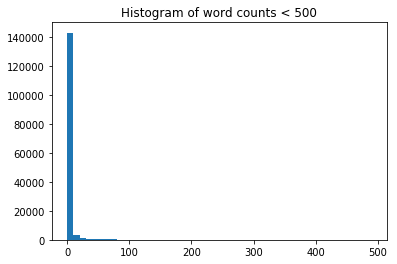

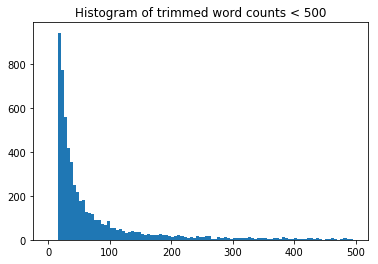

In [46]:
# Count of words for each appearance
hist_breaks = np.arange(0, 500, 10)
plt.hist(word_count_list, bins = hist_breaks)
plt.title('Histogram of word counts < 500')
plt.show()

# Too many words appear few times. Check out trimmed.
trimmed_word_counts = doc_term_mat_trimmed.sum(axis=0)
trimmed_word_list = trimmed_word_counts.tolist()[0]
hist_breaks = np.arange(0, 500, 5)
plt.hist(trimmed_word_list, bins = hist_breaks)
plt.title('Histogram of trimmed word counts < 500')
plt.show()

In [48]:
# Declare the TFIDF vectorizer.
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, max_features=6228, stop_words='english')

# Fit the vectorizer over the dataset
clean_texts = df['clean_tweet']
tf_idf_tweets = vectorizer.fit_transform(clean_texts)

#################################################################################################################

# For training 70% data will be 120,000 and remaining 30 % or 40,000 will be testing data
################################################################################################################

In [49]:
# Generate 40,000 random row indices
print('Splitting into train-test. Please wait!')
from sklearn.model_selection import train_test_split

y_targets = np.array([y[0] for y in tweet_data])

X_train, X_test, y_train, y_test = train_test_split(tf_idf_tweets,
                                                    y_targets,
                                                    test_size=40000,
                                                    random_state=42)
print('Done!')

Splitting into train-test. Please wait!
Done!


# Q4: Build a classifier that classifies the sentiment of a sentence.
############################################################################################################

In [51]:
print('Starting a standard Logistic Model training!')
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
print('Done.')

Starting a standard Logistic Model training!


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Done.


In [52]:
# Look at model object
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

# Q5: What is the accuracy of your model when applied to testing data?

In [57]:
## Compute results on the train and test set
train_probs = lr.predict_proba(X_train)
train_results = np.argmax(train_probs, axis=1)

test_probs = lr.predict_proba(X_test)
test_results = np.argmax(test_probs, axis=1)

Q5: What is the accuracy of your model when applied to testing data?

In [55]:
# Compute accuracies
train_logical_correct = [pred == actual for pred, actual in zip(train_results, y_train)]
train_acc = np.mean(train_logical_correct)

test_logical_correct = [pred == actual for pred, actual in zip(test_results, y_test)]
test_acc = np.mean(test_logical_correct)

print('Train accuracy: {}'.format(train_acc))
print('Test accuracy: {}'.format(test_acc))

Train accuracy: 0.7801666666666667
Test accuracy: 0.756375


Q6: What conclusions can you draw from the model?

In [58]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Remember:
# Precision is the proportion of correct predictions among all predicted
# Recall (sensitivity) is the proportion of correct predictions among all true actual examples
# F1 is the harmonic average of precision and recall
# Support is count of actual cases of specific class
# Here, each of the following is a pair of numbers, the first is for class 1 ('1') and second for class 0 ('0')
precision, recall, f1, support = precision_recall_fscore_support(y_test, test_results)

# Get the parts of the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, test_results).ravel()

# Print results
print(confusion_matrix(y_test, test_results))
print('='*35)
print('             Class 1   -   Class 0')
print('Precision: {}'.format(precision))
print('Recall   : {}'.format(recall))
print('F1       : {}'.format(f1))
print('Support  : {}'.format(support))

[[14596  5460]
 [ 4285 15659]]
             Class 1   -   Class 0
Precision: [0.77305227 0.74146503]
Recall   : [0.72776227 0.78514842]
F1       : [0.74972391 0.76268173]
Support  : [20056 19944]


In [59]:
print('Starting training regularized logistic regression')
from sklearn.linear_model import SGDClassifier
lr_reg = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15)
lr_reg.fit(X_train, y_train)
print('Done!')

Starting training regularized logistic regression
Done!


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [60]:
# Look at model object
lr_reg

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

Q7: Is it better to have a model per source?

In [63]:
## Compute results on the train and test set
train_probs = lr_reg.predict_proba(X_train)
train_results = np.argmax(train_probs, axis=1)

test_probs = lr_reg.predict_proba(X_test)
test_results = np.argmax(test_probs, axis=1)

In [64]:
# Compute accuracies
train_logical_correct = [pred == actual for pred, actual in zip(train_results, y_train)]
train_acc = np.mean(train_logical_correct)

test_logical_correct = [pred == actual for pred, actual in zip(test_results, y_test)]
test_acc = np.mean(test_logical_correct)

print('Train accuracy: {}'.format(train_acc))
print('Test accuracy: {}'.format(test_acc))

Train accuracy: 0.7526083333333333
Test accuracy: 0.745825
